# Hybrid Model (CNN and Transformer) - Convolutional Vision Transformer



In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, utils, Sequential
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, accuracy_score, f1_score
import seaborn as sns

### Reading The Data

In [2]:
#Use this for Google Colab training instead of manually uploading
!git clone https://github.com/nschultze/CS577Project.git

Cloning into 'CS577Project'...
remote: Enumerating objects: 3978, done.
remote: Counting objects: 100% (661/661), done.
remote: Compressing objects: 100% (634/634), done.
remote: Total 3978 (delta 29), reused 659 (delta 27), pack-reused 3317
Receiving objects: 100% (3978/3978), 10.43 GiB | 37.24 MiB/s, done.
Resolving deltas: 100% (168/168), done.
Updating files: 100% (3720/3720), done.


In [3]:
train_data_dir = 'CS577Project/train'
validation_data_dir = 'CS577Project/val'
test_data_dir = 'CS577Project/test'

#set the size of the image to be resized
target_size = (224, 224)

#using ImageDataGenerator for data augmentation and preprocessing (altering images to improve data variety)
datagen = ImageDataGenerator(
    rescale=1./255, #used to normalize the pixel values (dividing by max pixel value of 255)
    rotation_range=20, #randomly rotating the images by 20 degrees (almost like noise where we add variation)
    width_shift_range=0.2, #randomly shifting the images horizontally by 20 percent
    height_shift_range=0.2, #randomly shifting the images vertically by 20 percent
    shear_range=0.2, #setting the shear intensity to "stretch" the image
    zoom_range=0.2, #randomly zooming into the images by 20 percent
    horizontal_flip=True, #randomly flipping the images horizontally
    fill_mode='nearest') #because of the shifting, rotating, etc, there are missing pixels so we fill in those missing pixels with nearest valid values

#creating the generator for the training dataset
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size, #resizing
    batch_size=32,
    class_mode='binary') #binary for 2 labels

#create a new image gen for the validation and test that doesn't alter the images (other than normalize)
val_test_gen = ImageDataGenerator(rescale=1.0 / 255.0)

#creating the generator for the validation set
validation_generator = val_test_gen.flow_from_directory(
    validation_data_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    shuffle=False) #ensure that shuffle is False

#creating the generator for the testing dataset
test_generator = val_test_gen.flow_from_directory(
    test_data_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    shuffle=False)

Found 1887 images belonging to 2 classes.
Found 402 images belonging to 2 classes.
Found 410 images belonging to 2 classes.


## Building The Hybrid Model And Training

In [ ]:
#Replicating CvT (Convolutional Vision Transformer)
#building the EfficientNetB0 model section (CNN section)
efficient_net = EfficientNetB0(include_top=False, input_shape=(256, 256, 3), weights='imagenet') #do not freeze the weights (want to train the weights more like transfer learning)

#input value with the target/altered size
inp = tf.keras.Input(shape=(224, 224, 3))

#building the CvT (hybrid) model
x = efficient_net(inp)
x = layers.Reshape((-1, 1280))(x) #resize to accommodate the output of efficient net


patch_size = 32
num_patches = (224 // patch_size) * (224 // patch_size)
x = layers.Reshape((-1, num_patches, x.shape[-1]))(x)
x = MultiHeadAttention(num_heads=4, key_dim=x.shape[-1] // 4, dropout=0.1)(x, x)
#x = MultiHeadAttention(num_heads=4, key_dim=1280//4, dropout=0.1)(x, x) #adding the multi head attention to allow it to focus on different parts of the input
x = layers.GlobalAveragePooling2D()(x) #pooling to reduce input
x = layers.Dense(256, activation='relu')(x) #256
x = layers.Dropout(0.2)(x)
#adding a batch normalization for regularization
x = layers.BatchNormalization()(x)
#final output is passed into single neuron using sigmoid (good for binary classification)
output = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inp, outputs=output)

#compiling the model with an initial lr of 1e-3 (will change as training)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
#used to change the learning rate as it is training
# reduces learning rate based on validation loss
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

#printing the model
model.summary()

#training the model
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[lr_scheduler])  #adding the learning rate scheduler to change learning rate as it trains


#saving the model as a HDF5 file
model.save("cvt_model.h5")

16705208/16705208 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 efficientnetb0 (Functional  (None, 8, 8, 1280)           4049571   ['input_2[0][0]']             
 )                                                                                                
                                                                                                  
 reshape (Reshape)           (None, 49, 1280)             0         ['efficientnetb0[0][0]']      
                                                                                                  
 reshape_1 (Reshape)         

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


21/91 [=====>........................] - ETA: 5:46 - loss: 0.5272 - accuracy: 0.7539

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


91/91 [==============================] - 660s 7s/step - loss: 0.4013 - accuracy: 0.8281 - val_loss: 2.0276 - val_accuracy: 0.3881 - lr: 0.0010
Epoch 2/20
91/91 [==============================] - 599s 7s/step - loss: 0.2857 - accuracy: 0.8805 - val_loss: 2.9025 - val_accuracy: 0.6119 - lr: 0.0010
Epoch 3/20
91/91 [==============================] - 589s 6s/step - loss: 0.2762 - accuracy: 0.8915 - val_loss: 0.6739 - val_accuracy: 0.6119 - lr: 0.0010
Epoch 4/20
91/91 [==============================] - 609s 7s/step - loss: 0.2067 - accuracy: 0.9207 - val_loss: 2.0005 - val_accuracy: 0.6119 - lr: 0.0010
Epoch 5/20
91/91 [==============================] - 599s 7s/step - loss: 0.2110 - accuracy: 0.9175 - val_loss: 0.7863 - val_accuracy: 0.6119 - lr: 0.0010
Epoch 6/20
91/91 [==============================] - 595s 7s/step - loss: 0.1964 - accuracy: 0.9220 - val_loss: 1.2981 - val_accuracy: 0.6119 - lr: 0.0010
Epoch 7/20
91/91 [==============================] - 593s 7s/step - loss: 0.1506 - accur

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Plotting The Loss and Accuracy Of The Training

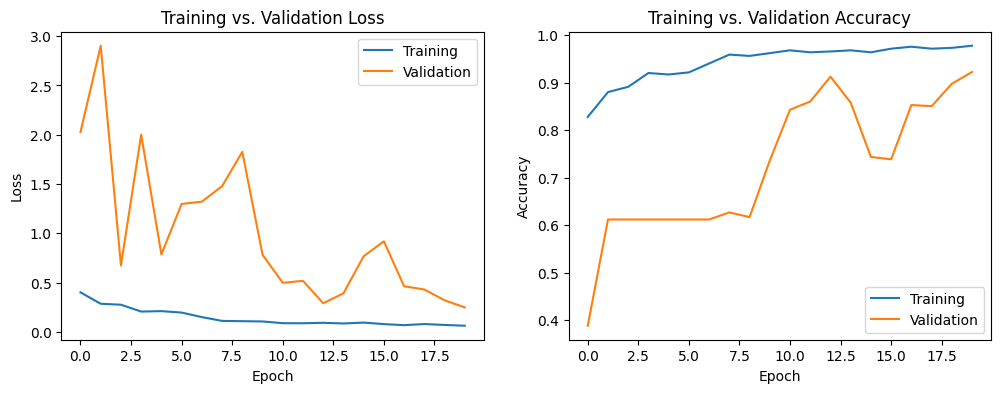

In [ ]:
#plotting the two figures of loss and accuracy
plt.figure(figsize=(12, 4))

#plotting the training & validation losses
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right') #placed at top right as loss should decrease as epochs increase

#plotting the training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right') #moved to lower right to not obstruct lines (acc should go upwards as epochs increase)

#saving the plots
plt.savefig("training_model_graphs.png")
plt.show()

### Evaluating The Model On the Testing Set

In [ ]:
#evaluating the model on the testing set
test_loss, test_acc = model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc}')

 4/13 [========>.....................] - ETA: 46s - loss: 0.2885 - accuracy: 0.9062 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


 7/13 [===============>..............] - ETA: 35s - loss: 0.2255 - accuracy: 0.9241

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


10/13 [======================>.......] - ETA: 22s - loss: 0.1585 - accuracy: 0.9469

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


13/13 [==============================] - 101s 8s/step - loss: 0.1376 - accuracy: 0.9537

Test accuracy: 0.9536585211753845


### Loading The Saved Model

In [4]:
#loading the model
loaded_model = tf.keras.models.load_model("cvt_model.h5")

### Using The Loaded Model To Evaluate Using Confusion Matrix

In [ ]:
#predictions based on the testing set
pred = loaded_model.predict(test_generator)

13/13 [==============================] - 102s 8s/step


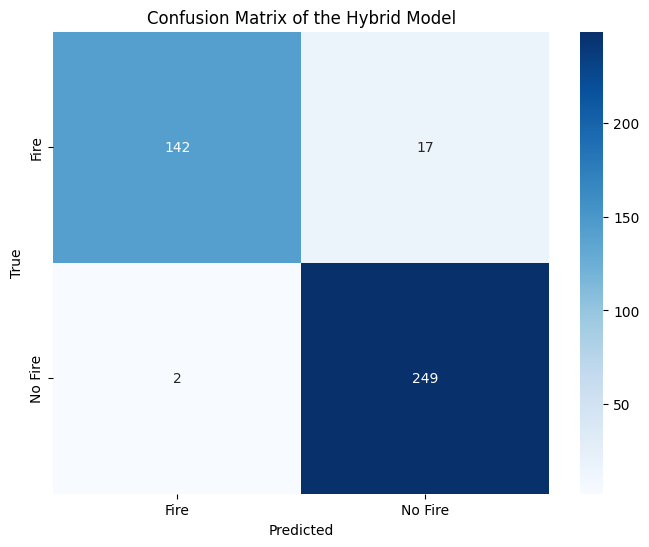

In [ ]:
threshold = 0.5  #setting the threshold for class differentiation

#classify predictions (probabilities) into class labels
pred_binary = (pred >= .5).astype(int).flatten()

#get the true labels
true_y = test_generator.classes

#calculate the confusion matrix
confusion_mat = confusion_matrix(true_y, pred_binary)

#displaying the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Fire', 'No Fire'], yticklabels=['Fire', 'No Fire'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of the Hybrid Model')
plt.show()

In [ ]:
#printing the classification report
print(classification_report(true_y, pred_binary, target_names = ["Fire", "No Fire"]))

#calcualting the precision, recall, accuracy, and f1 scores
precision = precision_score(true_y, pred_binary, average='macro')
recall = recall_score(true_y, pred_binary, average='macro')
accuracy = accuracy_score(true_y, pred_binary)
f1 = f1_score(true_y, pred_binary, average='macro')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

              precision    recall  f1-score   support

        Fire       0.99      0.89      0.94       159
     No Fire       0.94      0.99      0.96       251

    accuracy                           0.95       410
   macro avg       0.96      0.94      0.95       410
weighted avg       0.96      0.95      0.95       410

Precision: 0.9611006683375105
Recall: 0.9425568167581247
Accuracy: 0.9536585365853658
F1 Score: 0.9502716229069715


## Evaluating on Additional Images
### Additional Images Only
To run this section, make sure to create the necessary folders and place the images in the correct formatting (outer-most folder called "test_additional", next level has two folders called "fire" and "nofire", and lastly each of these two folders has the corresponding images)

In [14]:
test_additional_dir = "CS577Project/test_additional"

target_size = (224, 224)

#create a new image gen for the additional testing images
additional_test_gen = ImageDataGenerator(rescale=1.0 / 255.0)

#creating the generator for the testing dataset for additional images only
test_generator_additional = additional_test_gen.flow_from_directory(
    test_additional_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    classes=['fire', 'nofire'],
    shuffle=False)

Found 999 images belonging to 2 classes.


In [15]:
#evaluating the model on the testing set
test_loss, test_acc = loaded_model.evaluate(test_generator_additional)
print(f'\nTest accuracy: {test_acc}')

32/32 [==============================] - 102s 3s/step - loss: 0.5894 - accuracy: 0.7878

Test accuracy: 0.7877877950668335


In [17]:
#generating the prediction probabilities for the testing set of additional images
pred_additional = loaded_model.predict(test_generator_additional)

32/32 [==============================] - 103s 3s/step


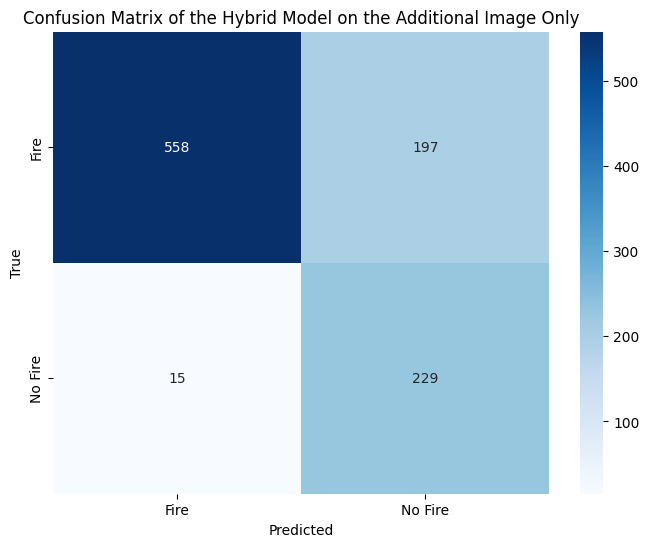

In [18]:
threshold = 0.5  #setting the threshold for class differentiation

#classify predictions (probabilities) into class labels
pred_additional_binary = (pred_additional >= .5).astype(int).flatten()

#get the true labels
true_additional_y = test_generator_additional.classes

#calculate the confusion matrix
confusion_mat_additional = confusion_matrix(true_additional_y, pred_additional_binary)

#displaying the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_additional, annot=True, fmt='d', cmap='Blues', xticklabels=['Fire', 'No Fire'], yticklabels=['Fire', 'No Fire'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of the Hybrid Model on the Additional Image Only')
plt.show()

In [21]:
#printing the classification report
print(classification_report(true_additional_y, pred_additional_binary, target_names = ["Fire", "No Fire"]))

#calcualting the precision, recall, accuracy, and f1 scores
precision_additional = precision_score(true_additional_y, pred_additional_binary, average='macro')
recall_additional = recall_score(true_additional_y, pred_additional_binary, average='macro')
accuracy_additional = accuracy_score(true_additional_y, pred_additional_binary)
f1_additional = f1_score(true_additional_y, pred_additional_binary, average='macro')

print(f'Precision: {precision_additional}')
print(f'Recall: {recall_additional}')
print(f'Accuracy: {accuracy_additional}')
print(f'F1 Score: {f1_additional}')

              precision    recall  f1-score   support

        Fire       0.97      0.74      0.84       755
     No Fire       0.54      0.94      0.68       244

    accuracy                           0.79       999
   macro avg       0.76      0.84      0.76       999
weighted avg       0.87      0.79      0.80       999

Precision: 0.7556903374874027
Recall: 0.8387987189230268
Accuracy: 0.7877877877877878
F1 Score: 0.7619717676676856


### Additional Images Plus Original Images
To run this section, make sure to create the necessary folders and place the images in the correct formatting (We will use the original "test" folder since the original images are extremely large and costly to move; thus, move the additional image folders "additional_fire" and "additional_nofire")

In [26]:
test_mixed_dir = "CS577Project/test"

target_size = (224, 224)

#create a new image gen for the additional testing images
mixed_test_gen = ImageDataGenerator(rescale=1.0 / 255.0)

#creating the generator for the testing dataset
test_generator_mixed = mixed_test_gen.flow_from_directory(
    test_mixed_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    classes=['fire', 'nofire'],
    shuffle=False)

Found 1409 images belonging to 2 classes.


In [27]:
#evaluating the model on the testing set
test_loss, test_acc = loaded_model.evaluate(test_generator_mixed)
print(f'\nTest accuracy: {test_acc}')

25/45 [===============>..............] - ETA: 1:57 - loss: 0.6355 - accuracy: 0.7688

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


30/45 [===================>..........] - ETA: 1:29 - loss: 0.6100 - accuracy: 0.7771

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


34/45 [=====================>........] - ETA: 1:20 - loss: 0.5398 - accuracy: 0.8033

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


45/45 [==============================] - 323s 7s/step - loss: 0.4537 - accuracy: 0.8368

Test accuracy: 0.8367636799812317


In [28]:
#generating the prediction probabilities for the mixed testing set
pred_mixed = loaded_model.predict(test_generator_mixed)

25/45 [===============>..............] - ETA: 1:16

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


30/45 [===================>..........] - ETA: 1:01

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


34/45 [=====================>........] - ETA: 57s 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


45/45 [==============================] - 237s 5s/step


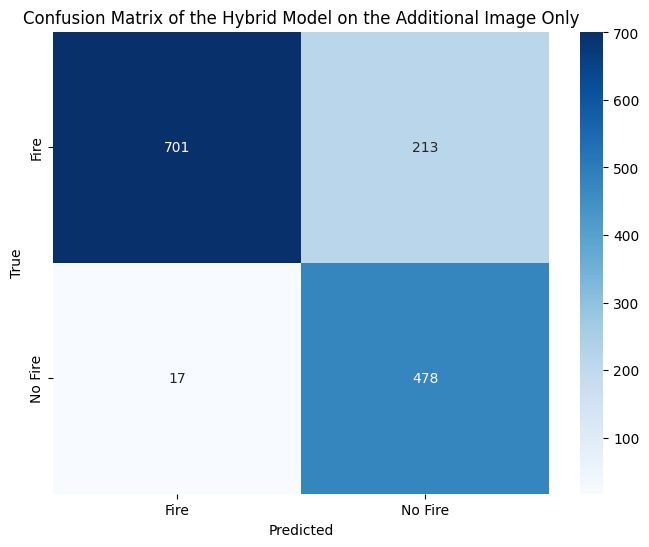

In [29]:
threshold = 0.5  #setting the threshold for class differentiation

#classify predictions (probabilities) into class labels
pred_mixed_binary = (pred_mixed >= .5).astype(int).flatten()

#get the true labels
true_mixed_y = test_generator_mixed.classes

#calculate the confusion matrix
confusion_mat_mixed = confusion_matrix(true_mixed_y, pred_mixed_binary)

#displaying the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_mixed, annot=True, fmt='d', cmap='Blues', xticklabels=['Fire', 'No Fire'], yticklabels=['Fire', 'No Fire'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of the Hybrid Model on the Additional Image Only')
plt.show()

In [30]:
#printing the classification report
print(classification_report(true_mixed_y, pred_mixed_binary, target_names = ["Fire", "No Fire"]))

#calcualting the precision, recall, accuracy, and f1 scores
precision_mixed = precision_score(true_mixed_y, pred_mixed_binary, average='macro')
recall_mixed = recall_score(true_mixed_y, pred_mixed_binary, average='macro')
accuracy_mixed = accuracy_score(true_mixed_y, pred_mixed_binary)
f1_mixed = f1_score(true_mixed_y, pred_mixed_binary, average='macro')

print(f'Precision: {precision_mixed}')
print(f'Recall: {recall_mixed}')
print(f'Accuracy: {accuracy_mixed}')
print(f'F1 Score: {f1_mixed}')

              precision    recall  f1-score   support

        Fire       0.98      0.77      0.86       914
     No Fire       0.69      0.97      0.81       495

    accuracy                           0.84      1409
   macro avg       0.83      0.87      0.83      1409
weighted avg       0.88      0.84      0.84      1409

Precision: 0.8340371025803305
Recall: 0.8663074950821121
Accuracy: 0.836763662171753
F1 Score: 0.8325697268789471
